In [1]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np
# from juices import Juices
# 假设有 3 台机器和 3 个操作
m = 3 # 机器数量
n = 2 # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3],[3, 1, 2]])

# 常数
K1 = 10
P = 5

# 量子比特数量
num_qubits = n * m + l

In [2]:
# #
# def pauli_z_term(index, num_qubits):
#     """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
#     __paulis = ['I'] * num_qubits
#     paulis[index] = 'Z'
#     return ''.join(paulis)  # 将列表转化为字符串
#
# def pauli_x_term(index, num_qubits):
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'X'
#     return ''.join(paulis)
# def pauli_y_term(index, num_qubits):
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'Y'
#     return ''.join(paulis)

In [3]:
def append__zz_term( qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)

def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)
def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [4]:
def get_cost_circuit1(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for h in range(l):
        # print(m * n + h)
        coef = - 2**h
        append__z_term(qc, m * n + h, coef * gamma)
    return qc

In [5]:
def get_cost_circuit2(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(n):
        for j in range(m):
            append__z_term(qc, i * m + j, (2 - m) * K1*gamma)
    # for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 != j2:
                    append__zz_term(qc, i * m + j1, i * m + j2, K1*gamma)
    return qc

In [6]:
def get_cost_circuit3(gamma, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for j in range(m):
        for i in range(n):
            coef = -1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * P
            append__z_term(qc, i * m + j, 2 * coef * p[i,j] * gamma)
        for h in range(l):
            coef = -1/2 * (np.sum(p[:, j]) - ( 2 ** l-1)) * P
            append__z_term(qc, m * n + h, -2 * (2 ** h) * coef * gamma)
        for i1 in range(n):
            for i2 in range(n):
                if i1 != i2:
                    coef = p[i1, j] * p[i2, j] * P
                    append__zz_term(qc, i1 * m + j, i2 * m + j, coef * gamma)
        for i in range(n):
            for h in range(l):
                coef = -1 * p[i,j] * 2 ** h * P
                append__zz_term(qc, i * m + j, m * n + h, coef * gamma)
        for h1 in range(l):
            for h2 in range(l):
                if h1 != h2:
                    coef = 2 ** h1 * 2 ** h2 * P
                    append__zz_term(qc, m * n + h1, m * n + h2, coef * gamma)
    return qc


In [7]:
def get_mixer_circuit(beta, n, m, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
        # qc.barrier()
    return qc

In [8]:
def get_mixer_circuit_xy(beta, n, m, l, K1, P, p, qc):
    for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1<j2:
                    qc.rxx(2 * beta, i * m + j1, i * m + j2)
                    qc.ryy(2 * beta, i * m + j1, i * m + j2)

In [9]:
def invert_counts(s):
    return s[::-1]

In [10]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params, n, m, l, K1, P, p):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    num_qubits = n * m + l
    qc = QuantumCircuit(num_qubits, num_qubits)  # 添加经典寄存器
    
    # 初始化量子态到 |+> 态
    qc.h(range(n * m + l))
    # print(qc)

    # for g, b in zip(gamma, beta):
    #     # 应用问题哈密顿量
    #     qc.append(PauliEvolutionGate(cost_hamiltonian, g), list(range(num_qubits)))
    #     # 应用混合哈密顿量
    #     qc.append(PauliEvolutionGate(mixer_hamiltonian, b), list(range(num_qubits)))
    length  = len(params)
    for i in range(int(length/2)):

        # get_cost_circuit1(gamma[i], n, m, l, K1, P, p, qc)
        get_cost_circuit2(gamma[i], n, m, l, K1, P, p, qc)
        # get_cost_circuit3(gamma[i], n, m, l, K1, P, p, qc)
        get_mixer_circuit(beta[i], n, m, l, K1, P, p, qc)

    # print(qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*m):]])
        x_ij = np.array([int(bit) for bit in bitstring[:(n*m)]]).reshape(n, m)

        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        E3 = 0
        for j in range(m):

            sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

            sum_zh = np.sum([2**h * z_h[h] for h in range(l)])

            max_value = max(0, sum_xp - sum_zh)

            E3 += P * (max_value)**2
        E =  E2
        # E = np.sum([2 ** h * z for h, z in enumerate(z_h)]) + K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)]) + P * alpha_s ** 2
        expectation += E * prob

    return expectation, counts

In [11]:
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(n, m, l, K1, P, p, params):
    def objective(params):
        expectation, _ = cost_function(params, n, m, l, K1, P, p)

        return expectation

    optimizer = COBYLA(rhobeg = 1.5, tol = 1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [12]:
import time

# 运行优化
# p_max = 6  # 最大层数

startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # 创建参数向量
        # print("init_point_temp"+ init_point_temp)
        result = optimize_qaoa(n, m, l, K1, P, p, init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, n, m, l, K1, P, p)
        # 寻找这20对点中最优的参数
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()
# params = np.random.rand(2 * p_max,2*np.pi)
# result = optimize_qaoa(n, m, l, K1, P, p, params)

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第：

In [13]:
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x, n, m, l, K1, P, p)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)


优化时间： 1054.7860708236694
Optimal parameters: [ 8.07136571 10.67242981  1.91029481  5.77040943  9.61996654  1.9925316 ]
Optimal value: 0.042000000000000016
Final expectation value: 0.042000000000000016
Final measurement counts: {'1001001': 591, '0100011': 588, '1000101': 587, '0010011': 583, '0010010': 576, '1000011': 568, '0101000': 566, '0100101': 560, '0100100': 553, '1001000': 545, '1000010': 544, '0101001': 536, '0100010': 535, '0010100': 534, '0010101': 528, '1000100': 525, '0011001': 522, '0011000': 517, '1100010': 3, '1001010': 3, '1100101': 3, '0111000': 2, '1000111': 2, '0101100': 2, '0100111': 2, '0100000': 2, '0110011': 2, '0110101': 2, '0110010': 2, '1101000': 1, '0010111': 1, '0111001': 1, '1011000': 1, '0101101': 1, '1010101': 1, '1010011': 1, '0010001': 1, '0011100': 1, '1010100': 1, '0011101': 1, '0011010': 1, '0101010': 1, '0110100': 1, '1100100': 1, '0010000': 1, '0100110': 1}


测试只代入最优参数，不优化，h2

In [14]:
# op_params = [11.84548248 , 2.37812652  , 1.93942811,  4.67546307,  1.58498361,  6.35763475]
# beta, gamma = op_params[:len(op_params)//2], op_params[len(op_params)//2:]
# qc2 = QuantumCircuit(num_qubits, num_qubits)
# length = len(op_params)
# qc2.h(range(n * m + l))
# for i in range(int(length/2)):
#
#         # get_cost_circuit1(gamma[i], n, m, l, K1, P, p, qc2)
#         get_cost_circuit2(gamma[i], n, m, l, K1, P, p, qc2)
#         # get_cost_circuit3(gamma[i], n, m, l, K1, P, p, qc2)
#         get_mixer_circuit(beta[i], n, m, l, K1, P, p, qc2)
#
# qc2.measure(range(num_qubits), range(num_qubits))
# backend = Aer.get_backend('qasm_simulator')
# result = execute(qc2, backend, seed_simulator=10, shots=10000).result()
# counts = result.get_counts(qc2)
# sorted_dict = {item[0][::-1]: item[1] for item in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
# # print("Final expectation value:", final_expectation)
# print("Final measurement counts:", sorted_dict)

In [15]:
from qiskit.visualization import plot_histogram

# 定义成本函数
def cost_function_xy(params, n, m, l, K1, P, p, optimal_params):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    opt_beta, opt_gamma = optimal_params[:len(optimal_params)//2], optimal_params[len(optimal_params)//2:]
    num_qubits = n * m + l
    qc = QuantumCircuit(num_qubits, num_qubits)  # 添加经典寄存器

    # 初始化量子态到 |+> 态
    qc.h(range(n * m + l))
    opt_length  = len(optimal_params)
    for i in range(int(opt_length/2)):

        # get_cost_circuit1(gamma[i], n, m, l, K1, P, p, qc)
        get_cost_circuit2(opt_gamma[i], n, m, l, K1, P, p, qc)
        # get_cost_circuit3(gamma[i], n, m, l, K1, P, p, qc)
        get_mixer_circuit(opt_beta[i], n, m, l, K1, P, p, qc)
    length = len(params)
    for i in range(int(length/2)):

        get_cost_circuit1(gamma[i], n, m, l, K1, P, p, qc)
        # get_cost_circuit2(gamma[i], n, m, l, K1, P, p, qc)
        get_cost_circuit3(gamma[i], n, m, l, K1, P, p, qc)
        get_mixer_circuit_xy(beta[i], n, m, l, K1, P, p, qc)
    # print(qc)

    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    # qc = transpile(qc, backend)
    # qobj = assemble(qc, shots=10000)
    # result = backend.run(qobj).result()
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # qc.draw(output = 'mpl', style='iqp')
    # plot_histogram(counts)
    # 计算期望值
    expectation = 0
    # x=0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*m):]])
        x_ij = np.array([int(bit) for bit in bitstring[:(n*m)]]).reshape(n, m)

        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        E3 = 0
        for j in range(m):

            sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

            sum_zh = np.sum([2**h * z_h[h] for h in range(l)])

            max_value = max(0, sum_xp - sum_zh)

            E3 += P * (max_value)**2
        E = E1 + E3
        # x+=1
        # print(E)
        expectation += E * prob
    # print("x:",x)
    return expectation, counts

In [16]:
# 优化 QAOA 参数
def optimize_qaoa_xy(n, m, l, K1, P, p, params, opt_params):
    def objective(params):
        expectation, _ = cost_function_xy(params, n, m, l, K1, P, p, opt_params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [17]:
import time

# 运行优化
# p_max = 6  # 最大层数

startTime = time.time()
# ansatz_final = object()
init_point_xy = np.array([])
counts_xy = {}
min_energy_xy = 0
final_result_xy = object()
optimal_params = final_result.x
for p1 in range(1, 4):
    min_energy_xy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point_xy
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # 创建参数向量
        # print("init_point_temp"+ init_point_temp)
        result = optimize_qaoa_xy(n, m, l, K1, P, p, init_point_temp, optimal_params)

        # print(result.x)
        optimal_params_xy = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function_xy(result.x, n, m, l, K1, P, p,optimal_params)
        # 寻找这20对点中最优的参数
        if min_energy_xy > energy:
            min_energy_xy = energy
            init_point_xy = optimal_params_xy
            counts_xy = counts_temp
            final_result_xy = result
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第：

运行时间： 1011.6069660186768
Optimal parameters: [10.72740152  2.5047204   2.23612249  3.45763058  6.49404417  2.27290114]
Optimal value: 14.046599999999998
Final expectation value: 14.046599999999998
Final measurement counts: {'1000100': 3812, '1000011': 2384, '1000101': 1860, '0010100': 497, '0101001': 390, '0101000': 315, '0010101': 212, '1000010': 129, '0011001': 98, '0100100': 62, '0010011': 51, '0010010': 48, '0100101': 36, '1001001': 25, '1001000': 25, '1010100': 8, '0100010': 6, '1100011': 6, '1000110': 4, '0100111': 3, '1010011': 3, '0100011': 3, '1000111': 2, '0011000': 2, '0000100': 2, '1000000': 2, '0101010': 2, '1100101': 2, '1001100': 2, '1101001': 1, '0110100': 1, '0000101': 1, '1001011': 1, '0000011': 1, '1000001': 1, '0010000': 1, '0110011': 1, '1100100': 1}


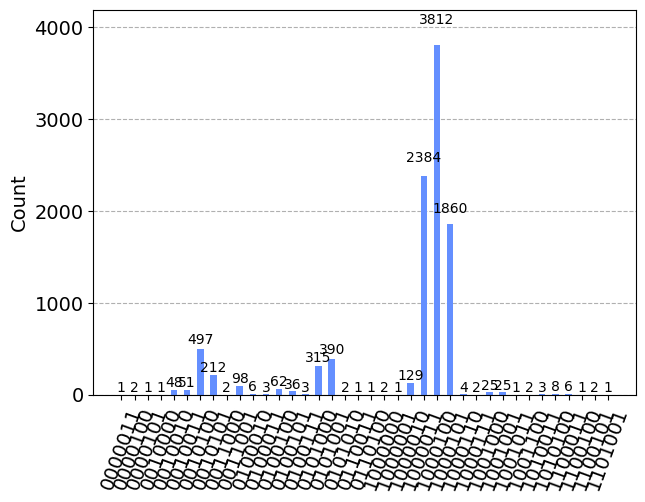

In [18]:
# 输出结果
print("运行时间：",endTime - startTime)
print("Optimal parameters:", final_result_xy.x)
print("Optimal value:", final_result_xy.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation_xy, final_counts_xy = cost_function_xy(final_result_xy.x, n, m, l, K1, P, p, optimal_params)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict_xy = {item[0][::-1]: item[1] for item in sorted(counts_xy.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation_xy)
print("Final measurement counts:", sorted_dict_xy)
plot_histogram(sorted_dict_xy)

In [19]:
# 计算最终的能量
energy, counts_temp = cost_function_xy(final_result_xy.x, n, m, l, K1, P, p,optimal_params)
plot_histogram(counts_temp)
print(energy)
print(counts_temp)

30.084699999999998
{'00010010': 49, '10001001': 112, '00100011': 4, '10010010': 123, '10001010': 1824, '01000010': 2, '11100001': 1944, '11001100': 10, '01010100': 1908, '10001100': 71, '11010001': 54, '01110100': 1, '01001010': 216, '00100010': 32, '11010100': 198, '10100001': 200, '00010100': 175, '00001010': 115, '00100001': 1984, '01100001': 136, '00100101': 4, '10010100': 125, '01001100': 111, '11001010': 91, '11100011': 4, '00110001': 2, '10001101': 4, '01010010': 12, '11001001': 38, '10100010': 26, '11100010': 156, '10100000': 1, '00001001': 30, '01010000': 2, '00010001': 43, '10101010': 6, '01100100': 44, '00100000': 3, '10010001': 14, '01010101': 1, '10001011': 2, '00011001': 2, '01100010': 11, '00100110': 2, '11000001': 2, '10101001': 2, '11100101': 3, '10011010': 2, '10011100': 1, '11001110': 1, '01000100': 4, '10100100': 18, '11011001': 1, '00000001': 3, '11100100': 18, '11101001': 2, '01101100': 6, '10110010': 2, '00100100': 1, '11101010': 1, '11010010': 7, '11100110': 2, 

In [24]:
expectation = 0
bitstring = "0010101"
z_h = np.array([int(bit) for bit in bitstring[(n*m):]])
x_ij = np.array([int(bit) for bit in bitstring[:(n*m)]]).reshape(n, m)

E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = K1 * np.sum([(np.sum(x_ij[i]) - 1) ** 2 for i in range(n)])
# alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
E3 = 0
e1=0
e2=0
for j in range(m):

    sum_xp = np.sum([x_ij[i][j] * p[i][j] for i in range(n)])

    sum_zh = np.sum([2**h * z_h[h] for h in range(l)])

    max_value = max(0, sum_xp - sum_zh)
    e1+=sum_xp
    e2+=sum_zh
    E3 += P * (max_value)**2
E =  E1 + E2 + E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

1
0
40
